# Checkpoint 2

**Due: Friday, 6 November, 2020 at 5:00pm GMT**

### Read This First
1. Use the constants provided in the cell below. Do not use your own constants.

2. Put the code that produces the output for a given task in the cell indicated. You are welcome to add as many cells as you like for imports, function definitions, variables, etc. **Additional cells need to be in the proper order such that your code runs correctly the first time through.**

3. **IMPORTANT!** Before submitting your notebook, clear the output by clicking *Restart & Clear Output* from the *Kernel* menu. If you do not do this, the file size of your notebook will be very large.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

from scipy.sparse.linalg import splu
from scipy.sparse import diags
from scipy.sparse import identity
from scipy.linalg import eigh_tridiagonal
from scipy import integrate
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

# Task 1 (25p)

Find numerically the first 101 lowest eigenvalues (“energies”) of the discrete Hamiltonian matrix, H, for V=0 and x=0,...,L, with L=100, dx=1/8 and with reflecting boundary conditions:

$
\begin{align}
\psi_N \equiv \psi_{N-1},
\end{align}
$

$
\begin{align}
\psi_{-1} \equiv \psi_0,
\end{align}
$

Here the index -1 denotes the element to the left of the element zero, not the element N-1 as in Python. Note that indices $-1, N$ refer to elements of $\psi$ that are outside the matrix H.

Hint: The eigenvalues, $w_n$, should be

$
\large
\begin{align}
w_n = \frac{2\left(1 - \cos (\frac{n \pi}{N}) \right)}{dx^2}
\end{align}
$

for n=0, 1,..., 100. The corresponding (non-normalized) eigenvectors, $v_n$ are

$
\large
\begin{align}
v_n = \cos \left( \frac{n \pi x}{L} \right)
\end{align}
$

for x=0, dx,..., (N-1)dx.

In [2]:
### Values for task 1
L  = 100
dx = 1/8
N  = int(L/dx)
print(f"Matrix size: {N}.")

Matrix size: 800.


In the cell below, compute the 101 lowest eigenvalues given the values of V, L, and dx from above. The function, `task1` should return an array of the eigenvalues.

It may be useful to write a generalized function for creating the Hamiltonian given values of N, dx, and V.

In [3]:
# The function laplacian() takes as parameters the total number of x-points (N) to use for the creation of the array
# and the value of dx, and returns the matrix representation of the Laplacian operator.

def laplacian(N, dx):
    
    main = [-2]*N
    offs = [1]*N
    # csc == compressed sparse column & csr == compressed sparse row
    lapl = diags([main,offs,offs],[0,1,-1]).tocsc().tocsr()   
    # the following corrections represent the boundary conditions given above
    lapl[0,0] = -1   
    lapl[N-1,N-1] = -1
    lapl = (1/(dx**2)) * lapl
    return lapl

# The function hamiltonian() takes as parameters the total number of x-points (N) to use for the creation of the array,
# the value of dx and the potential V, and returns the matrix representation of the Hamiltonian operator.

def hamiltonian(N, dx, V):
    
    lapl = laplacian(N,dx)
    hamil = -lapl + V
    return hamil

In [4]:
# The function task1() creates the Hamiltonian with the given values of N and dx, and a potential of 0, then 
# extracts the diagonal and off-diagonals and using those it finds and returns the 101 smallest magnitude eigenvalues.

def task1():
    
    hamil = hamiltonian(N,dx,0)
    d = np.diag(hamil.toarray(),0)  # diagonal
    e = np.diag(hamil.toarray(),1)  # off-diagonals
    eigvals, eigvects = eigh_tridiagonal(d, e, select='i', select_range=(0,100))
    return eigvals

## Testing task 1

The cell below will run your function and compare it with the expected values.

Time to solution: 0.06552624702453613 seconds.


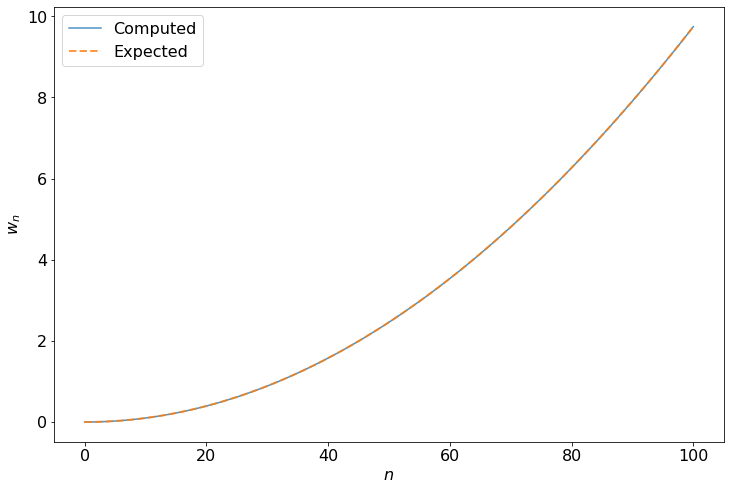

Max difference is 1.7702117765407015e-11.


In [5]:
t1 = time.time()
ww = task1()
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")

my_n = np.arange(101)
ww_expected = 2 * (1 - np.cos(my_n*np.pi/N)) / dx**2

plt.plot(my_n, ww, label='Computed', alpha=0.8)
plt.plot(my_n, ww_expected, label='Expected', linewidth=2, linestyle='--', alpha=0.8)
plt.xlabel(r'$n$')
plt.ylabel(r'$w_{n}$')
plt.legend()
plt.show()

diff = np.abs(ww - ww_expected) / np.max(np.abs([ww, ww_expected]), axis=0)
print (f"Max difference is {diff[1:].max()}.")
assert (diff[1:] < 1e-6).all()

# Task 2 (5p)

Select dx as a negative power of two ($dx=2^{-n}$ for n>0) such that the 101th eigenvalue differs from the dx$\rightarrow$0 limiting value of

$
\begin{align}
w_{101,exact} = \frac{(100\pi/N)^{2}}{dx^2}
\end{align}
$

by less than 0.1%, i.e., $|w_{101}/w_{101,exact}-1|<0.001$.

Motivation: selecting a sufficiently small dx is required to obtain a good approximation to the original (continuous) equation (1) for subsequent tasks.

In the cell below, compute a value of dx that satisfies the above contraint. The function `task2` should return the value of dx that you have calculated.

In [6]:
# The function task2() loops through several integer values of n. Each time it calculates the corresponding dx,
# creates the Hamiltonian and finds the 101th smallest magnitude eigenvalue, to check it against the exact from the
# equation as given above. When the difference is less than the tolerance (0.001), the function stops and returns
# the optimal value for dx.

def task2():
    
    ns = np.arange(1,10,1)
    for n in ns:
        
        dx = (2.0)**(-n)
        N  = int(L/dx)
        hamil = hamiltonian(N,dx,0)
        d = np.diag(hamil.toarray(),0)  # diagonal
        e = np.diag(hamil.toarray(),1)  # off-diagonals
        eigvals, eigvects = eigh_tridiagonal(d, e, select='i', select_range=(100,100))  # only the 101th eigenvalue
        exact = (((100*np.pi)/N)**2)/(dx**2)
        diff = np.abs( (eigvals[0] / exact) -1)
        
        if(diff<0.001):
            print(f"The optimal value for dx is equal to {dx}")
            return(dx)

## Testing task 2

The cell below will run the `task2` function. We will verify that value of dx return satisfies the criterion outlined above.

In [7]:
t1 = time.time()
my_dx = task2()
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")


The optimal value for dx is equal to 0.03125
Time to solution: 0.07071256637573242 seconds.


# Task 3 (20p)

Solve equation (1) with the initial condition (2) (the Schroedinger equation and the Gaussian function from the checkpoint's description) for V(x)=0, on a domain x=0...100, for t=0...4 and dx from task 2. Plot $|\psi(x,t)|^2$ and determine its mean given by

$
\large
\begin{align}
<x>\ = \int_{0}^{100} |ψ(x)|^2 x dx.
\end{align}
$

The mean should be equal to 79$\pm$-1.

Hint: use the procedure for creating the Hamiltonian matrix from tasks 1, 2. This will reduce the amount of coding required.

In [8]:
### Constants for task 3 and 4
x0     = 15
v      = 16
sigma2 = 5
tmax   = 4

## Task 3 plot and result

In the cell(s) below, do the following:
1. Solve equation (1) for t=0...4 and plot $|\psi(x,t=0)|^2$ and $|\psi(x,t=tmax)|^2$ as a function of x.
2. Compute the mean of the final position and print the value. The correct result should be between 78 and 80.

Don't forget to nomalize your Gaussian initial condition so that the total probability $\int_0^L |\psi(x,t=0)|^2 dx=1$. 

You do not have to wrap up the calculation in a function "task3()", but doing so may help to reduce the amount of coding for tasks 4-6.

In [9]:
# The function get_space() takes as parameters the left and right (min and max) values of the space, and 
# selects a dx value depending on the boolean 'use_my_dx'. Then, it creates an array of the x-values to be used. 
# The function returns the array of xs and the value of dx.

def get_space(a,b):
    
    if(use_my_dx):
        dx = my_dx
    else:
        dx = (2.0)**(-6)   # small enough to ensure high accuracy in the solutions
    
    xs = np.arange(a,b+dx,dx)
    return xs, dx

# The function get_time() uses the specified dt to create an array of the t-values to be used. 
# The function returns the array of ts and the value of dt.

def get_time():
    
    dt = (2.0)**(-10)   # small enough to ensure high accuracy in the solutions
    ts = np.arange(0,tmax+dt,dt)
    return ts, dt

In [10]:
# The function initial() takes as parameters the x-points and the velocity v, and uses equation (2) to
# create and return the wavefunction of the initial condition. 

def initial(xs,v):
    
    expr = ((xs-x0)**2)/(2*sigma2)
    expr2 = (1j*v*xs)/2
    psi0 = np.exp(-expr+expr2)
    return psi0

# The function normalize() takes as parameters the initial wavefunction and the x-points, and integrates it 
# from 0 to L with respect to x. Then, it calculates the normalization factor and returns the normalized wavefunction.

def normalize(psi0, xs):
    
    psi0_sq = (psi0 * psi0.conj()).real
    I = integrate.simps(psi0_sq,xs)
    Norm = 1/np.sqrt(I)
    psi0 = Norm*psi0
    return psi0

# The function mean() takes as parameters a wavefunction and the x-points, and integrates the square of the 
# wavefunction times x, from 0 to L with respect to x. The integral represents the mean position, which is returned
# by the function.

def get_mean(psi_n, xs):
    
    psiN_sq = (psi_n * psi_n.conj()).real
    I = integrate.simps(psiN_sq*xs,xs)
    
    return I

In [11]:
# The function task3() takes as parameters the velocity 'v', the potential 'V' and the Boolean value 'plotBool' to 
# indicate if a plot of the wavefunctions is desired. Then, it uses all the functions explained above to set up space, 
# time, the initial condition and the Hamiltonian operator. Next, matrices A and b (as explained in the lectures) are
# created and then used for solving the Schroedinger equation. Finally, the wavefunctions for all time-steps are returned.


use_my_dx=True   # indication to use the my_dx value from task2()

def task3(v, V, plotBool):

    xs, dx = get_space(0,100)
        
    N = len(xs)
    ts, dt = get_time()

    psi0 = initial(xs,v)
    psi0 = normalize(psi0,xs)
    hamil = hamiltonian(N,dx,V)  
    
    A = (identity(N)+0.5j*hamil*dt).tocsc()
    b = (identity(N)-0.5j*hamil*dt).tocsc()
    A = splu(A)    # LU decomposition of a sparse, square matrix.
    
    psi_n = psi0.copy()
    
    psis = np.empty((len(ts),len(psi0)),dtype=complex)  # an array to store the wavefunction at each time-step
    
    for n in range(len(ts)):
        psis[n] = psi_n
        psi_n = A.solve(b*psi_n)
    
    if(plotBool):
        plt.plot(xs,psi0 * psi0.conj(), label = '$|\psi\ (x,t=0)|^2$' )
        plt.plot(xs,psi_n * psi_n.conj(), label = '$|\psi\ (x,t=tmax)|^2$')
        plt.xlabel('x')
        plt.ylabel('$|\psi\ (x,t)|^2$')
        plt.legend()
        plt.show()
        
    mean = get_mean(psi_n,xs)
    
    return psis, mean


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


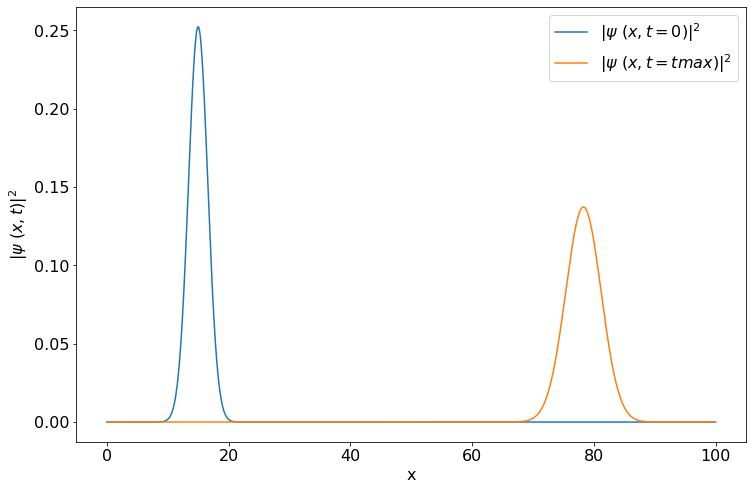

The mean of the final position is 78.286
Time to solution: 1.2542905807495117 seconds.


In [12]:
t1 = time.time()
run, mean = task3(v, 0, plotBool=True)
t2 = time.time()
print(f"The mean of the final position is {mean:.3f}")
print (f"Time to solution: {t2-t1} seconds.")

# Task 4 (10p)

Now repeat task 3 for a potential made up of regularly spaced wells such that

V=70 for |x-i| < 0.25 where i=0,1,...,100,

and V=0 elsewhere.

Plot the potential. It should be $V=70$ for $x=0...0.25$, $V=0$ for $x=0.25...0.75$, $V=70$ for $x=0.75...1.25$, and so on.

Determine the mean of $|\psi(x,t)|^2$ as before, with accuracy $\pm$1.

Make sure that dx and dt are sufficiently small to achieve this accuracy!

In the cell below, create the potential and plot it over the range [0, 3].

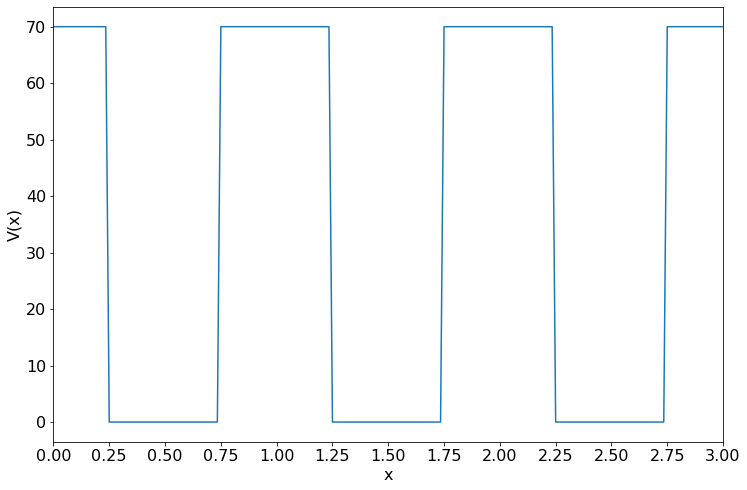

In [13]:
# The function plot_V() takes as parameters the x-positions, the values of the potential over the x-positions, 
# and a value xmax, and then plots the potential from 0 to xmax.

def plot_V(xs, values, xmax):
    
    plt.plot(xs,values)
    plt.xlim((0,xmax))
    plt.xticks(np.arange(0,xmax+0.25,0.25))
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.show()

# The function potential() takes as parameters the Boolean value 'plotBool' to indicate if a plot of the  
# potential is desired, and another Boolean 'randomBool' to indicate whether to use randomness to create a
# disordered potential (as required in task7). Then, it finds where the x position is an integer and sets the
# potential value to 70 for a calculated width. Finally it returns the compressed matrix representing the potential V.
    
def potential(plotBool, randomBool):

    xs, dx = get_space(0,100)
        
    ints = np.arange(0,101,1.0)
    values = np.zeros(len(xs))
    
    if(randomBool):
        widths = np.random.uniform(0.125,0.375,len(ints))
        widths = widths/dx
    else:
        widths = np.full(len(ints), int(0.25/dx))
    
    for i in ints:
        width = int(widths[int(i)])
        idx = np.where(xs==i)[0][0]
        left = np.maximum(0, idx-width)  # to ensure correct potential at x=0
        values[left:idx+width] = 70   # set the potential to 70 according to the width
    
    if(plotBool):
        plot_V(xs,values,3)
        
    potential = diags([values],[0]).tocsr().tocsc()
    
    return potential

use_my_dx=False # indication to NOT use the my_dx value from task2() because it is not small enough for sufficient accuracy
V = potential(plotBool=True, randomBool=False)

# Task 4 continued

In the cell below, repeat task 3 with the new potential.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


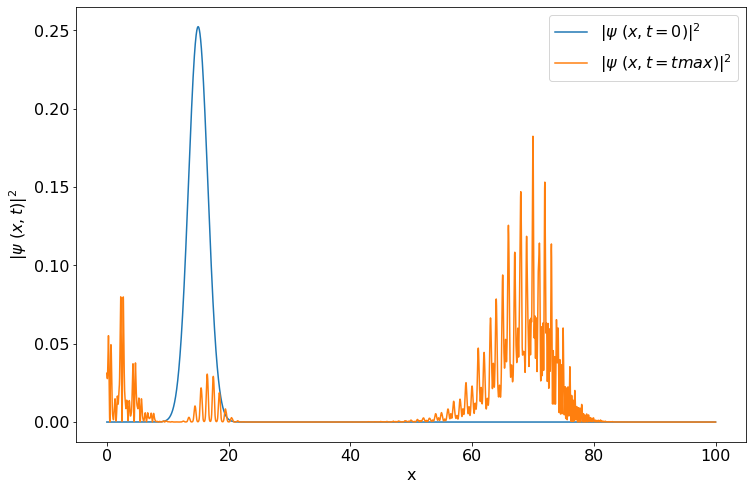

The mean of the final position is 57.608
Time to solution: 2.2736852169036865 seconds.


In [14]:
t1 = time.time()
# same as task3 but with potential=V (not 0) & smaller dx (from get_space() )
psis, mean = task3(v, V, plotBool=True)  
t2 = time.time()
print(f"The mean of the final position is {mean:.3f}")
print (f"Time to solution: {t2-t1} seconds.")

# Task 5 (15p)

Calculate the probability $P_{1/2}$ of the particle moving through the point x=L/2 by integrating the probability current 

$
\large
\begin{align}
j = (\psi^*  \frac{\partial \psi}{\partial x} -
\psi \frac{\partial \psi^*}{\partial x})(x=L/2)
\end{align}
$

over time, for t=0...4. The probability can deviate from the true value by no more than $\pm$0.01 (hint: the correct value is between 0.5 and 1).

In the cell below, calculate the probability and print your answer.

In [15]:
# The function task5() takes as parameter an array containing the wavefunctions over all time-steps. Next, it 
# finds the point where x=L/2 and  creates a new wavefunction fixed at x-dx over all times, and calculates its conjugate. 
# That is repeated for the next value of x too (x+dx). The reason these two points were selected is that they are
# needed for symmetric discrete differentiation, where f'(x) = f(x+h)-f(x-h)/2h. Then the probability current is calculated
# (as in the equation above) and integrated from t=0 to t=tmax. Finally the function returns the probability P_1/2.

def task5(psis):
    
    xs, dx = get_space(0,100)
    N = len(xs)
    ts, dt = get_time()
    
    idx = np.where(xs==(L/2))[0][0]
    psi = psis[:,idx-1]
    psi_star = psi.conj()
    psi2 = psis[:,idx+1]
    psi_star2 = psi2.conj()
    
    j = (psi_star * (psi2-psi)/(2*dx) - psi * (psi_star2-psi_star)/(2*dx))/(1j)
    I = integrate.simps(j,ts)
    prob = I.real
    
    return (prob)

In [16]:
t1 = time.time()
prob = task5(psis)
t2 = time.time()
print(f"The probability of the particle moving through x=L/2 is {prob:.5f} ")
print (f"Time to solution: {t2-t1} seconds.")

The probability of the particle moving through x=L/2 is 0.82568 
Time to solution: 0.0012555122375488281 seconds.


# Task 6 (15p)

Plot the probability $P_{1/2}$ as a function of particle energy E=0...100, for at least 100 equally-spaced values from this range. All $P_{1/2}$ values should be within $\pm$0.01 of the true values. Use the formula 

$
\large
\begin{align}
E = \frac{1}{4} v^2
\end{align}
$

to convert between energy and velocity (valid for Eqs. (1,2)).

Bonus question: can you explain why the plot looks like this?

Plot the probability in the cell below.

In [17]:
# The function task6() loops through 100 evenly spaced values of energy from 0 to 100. The corresponding velocity v
# is calculated each time and then task3() is called to obtain the wavefunctions. Next, task5() is called to
# calculate and return the probability P_1/2, where it is stored in an array. Finally, the probabilities P_1/2 are 
# plotted as a function of the particle energy.

def task6():
    
    V = potential(plotBool=False, randomBool=False)
    energies = np.arange(0,101,1)
    probs = np.zeros(len(energies))
    
    for e in energies:
        v = np.sqrt(4*e)
        psis, mean = task3(v, V, plotBool=False)  
        prob = task5(psis)
        idx = np.where(energies==e)[0][0]
        probs[idx] = prob
        
    plt.plot(energies,probs)
    plt.xticks(np.arange(0,101,10))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Particle Energy')
    plt.ylabel('Probability $P_{1/2}$')
    plt.show()
    
    return probs

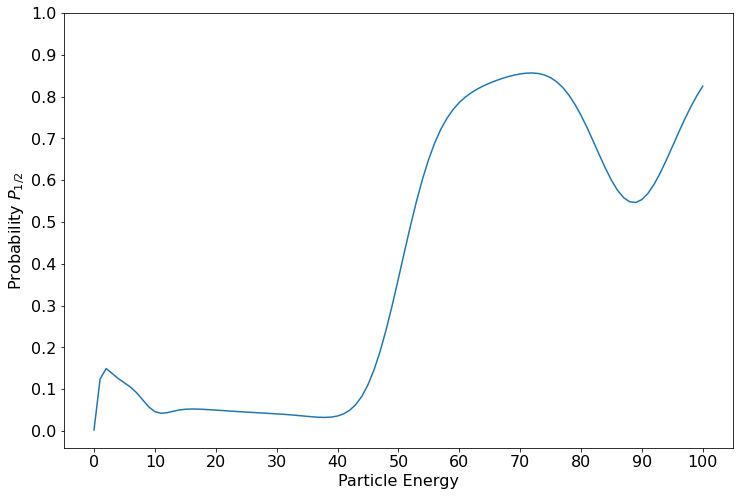

Time to solution: 194.94462943077087 seconds.


In [18]:
use_my_dx=False  # indication to NOT use the my_dx value from task2() because it is not small enough for sufficient accuracy
t1 = time.time()
probs = task6()
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")

# Task 7 (10p)

Assume again the initial condition of equation (2) with v=16, and consider a disordered potential in which

V=70 for |x-i| < b$_i$ where i=0,1,...,100,

and b$_i$ is a random variable uniformly distributed on [0.125, 0.375].

Find the probability $P_{1/2}$ by averaging over 100 realizations of the random potential (must be accurate to $\pm$0.02). Plot the histogram of $P_{1/2}$. Comment on the value of $P_{1/2}$ compared with task 5.

In [19]:
# The function task7() runs 100 times, each with a different random disordered potential. Task3() is called to return
# the wavefunctions and task5() is called to calculate the probability P_1/2 each time.
# Finally a histogram of the probabilities P_1/2 is plotted, and their average is calculated and printed out.

def task7():
    
    v = 16
    runs = 100
    probs = np.zeros(runs)
    
    for i in range(runs):  
        V = potential(plotBool=False, randomBool=True)  # disordered potential
        psis, mean = task3(v, V, plotBool=False)  
        prob = task5(psis)
        probs[i] = prob
    
    fig, ax = plt.subplots()
    bins=11
    plt.hist(probs, bins, density = False, rwidth=0.97) 
    xmin = np.min(probs)
    xmax = np.max(probs)
    plt.xticks(np.linspace(xmin,xmax,bins+1))
    plt.xlabel('Probability $P_{1/2}$')
    plt.ylabel("Count")
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    #plt.xticks(fontsize=15, rotation=20)
    plt.show()

    avg = np.average(probs)
    print(f"The average probability over {runs} realisations is {avg:.4f}")
    
    return avg

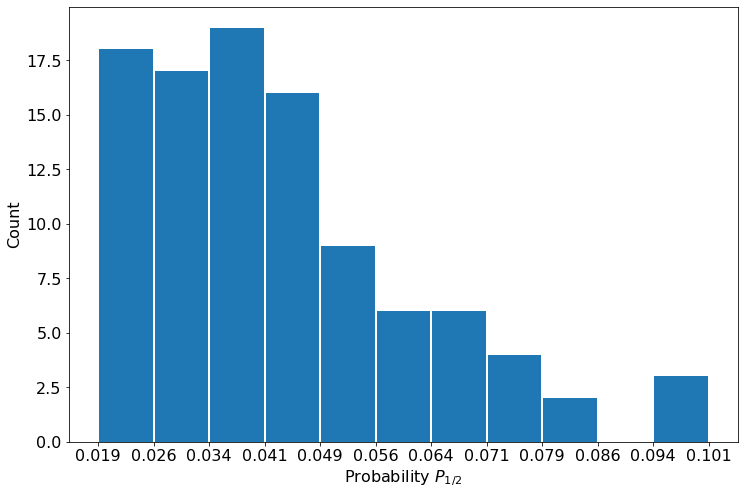

The average probability over 100 realisations is 0.0438

The probability in this case is much lower than in task 5. This is an indication that localizaton has been achieved. 
The reason is that the potential is not a regular pattern of equally spaced wells anymore, but instead it is disordered with random widths b_i. 
Therefore the particle cannot move through the potential anymore, but instead gets trapped in the wells and does not move.

Time to solution: 101.13021421432495 seconds.


In [20]:
use_my_dx=True  # indication to use the my_dx value from task2() (good enough for desired accuracy)
t1 = time.time()
avg = task7()
t2 = time.time()
print("\nThe probability in this case is much lower than in task 5. This is an indication that localizaton has been "+
        "achieved. \nThe reason is that the potential is not a regular pattern of equally spaced wells anymore, but "+
        "instead it is disordered with random widths b_i. \nTherefore the particle cannot move through the potential "+
        "anymore, but instead gets trapped in the wells and does not move.\n")

print (f"Time to solution: {t2-t1} seconds.")